In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
from matplotlib.text import Text

In [ ]:
# Get Euros 2024 games
parser = Sbopen()
df_games = parser.match(competition_id=55, season_id=282)

# Create empty dribbles dataframe
columns = ['match_id', 'period', 'timestamp', 'minute', 'second', 'possession', 'duration', 'match_id', 'type_name', 'outcome_name', 'team_name', 'player_name', 'x', 'y']
df_dribbles = pd.DataFrame(columns=columns)

# Loop through matches and collect dribbling events
for match_id in df_games['match_id']:
    df, related, freeze, tactics = parser.event(match_id)
    dribble_events = df[df['type_name'] == 'Dribble']

    df_dribbles = pd.concat([df_dribbles, dribble_events[columns]], ignore_index=True)

df_dribbles.info()

/var/folders/5d/_v0r0r510wncd2w765n36ksw0000gn/T/ipykernel_48608/764343096.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dribbles = pd.concat([df_dribbles, dribble_events[columns]], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   match_id      1280 non-null   object 
 1   period        1280 non-null   object 
 2   timestamp     1280 non-null   object 
 3   minute        1280 non-null   object 
 4   second        1280 non-null   object 
 5   possession    1280 non-null   object 
 6   duration      1280 non-null   float64
 7   match_id      1280 non-null   object 
 8   type_name     1280 non-null   object 
 9   outcome_name  1280 non-null   object 
 10  team_name     1280 non-null   object 
 11  player_name   1280 non-null   object 
 12  x             1280 non-null   float64
 13  y             1280 non-null   float64
dtypes: float64(3), object(11)
memory usage: 140.1+ KB


In [64]:
df_dribbles.groupby('player_name').size().sort_values(ascending=False)

player_name
Nicholas Williams Arthuer      32
Kylian Mbappé Lottin           28
Khvicha Kvaratskhelia          28
Lamine Yamal Nasraoui Ebana    27
Jeremy Doku                    27
                               ..
László Kleinheisler             1
Marc Guehi                      1
Marin Pongracic                 1
Mario Mitaj                     1
Lazar Samardžić                 1
Length: 305, dtype: int64

outcome_name                 Complete  Incomplete  total         team
player_name                                                          
Bukayo Saka                        11           8     19      England
Dan Ndoye                          12           7     19  Switzerland
Jude Bellingham                    12           8     20      England
Jamal Musiala                      10          11     21      Germany
Ousmane Dembélé                    14           8     22       France
Lamine Yamal Nasraoui Ebana        12          15     27        Spain
Jeremy Doku                        15          12     27      Belgium
Khvicha Kvaratskhelia              14          14     28      Georgia
Kylian Mbappé Lottin               18          10     28       France
Nicholas Williams Arthuer          15          17     32        Spain


/var/folders/5d/_v0r0r510wncd2w765n36ksw0000gn/T/ipykernel_48608/2295990060.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(top_dribblers['Complete'][i] + v/2, i, str(v),


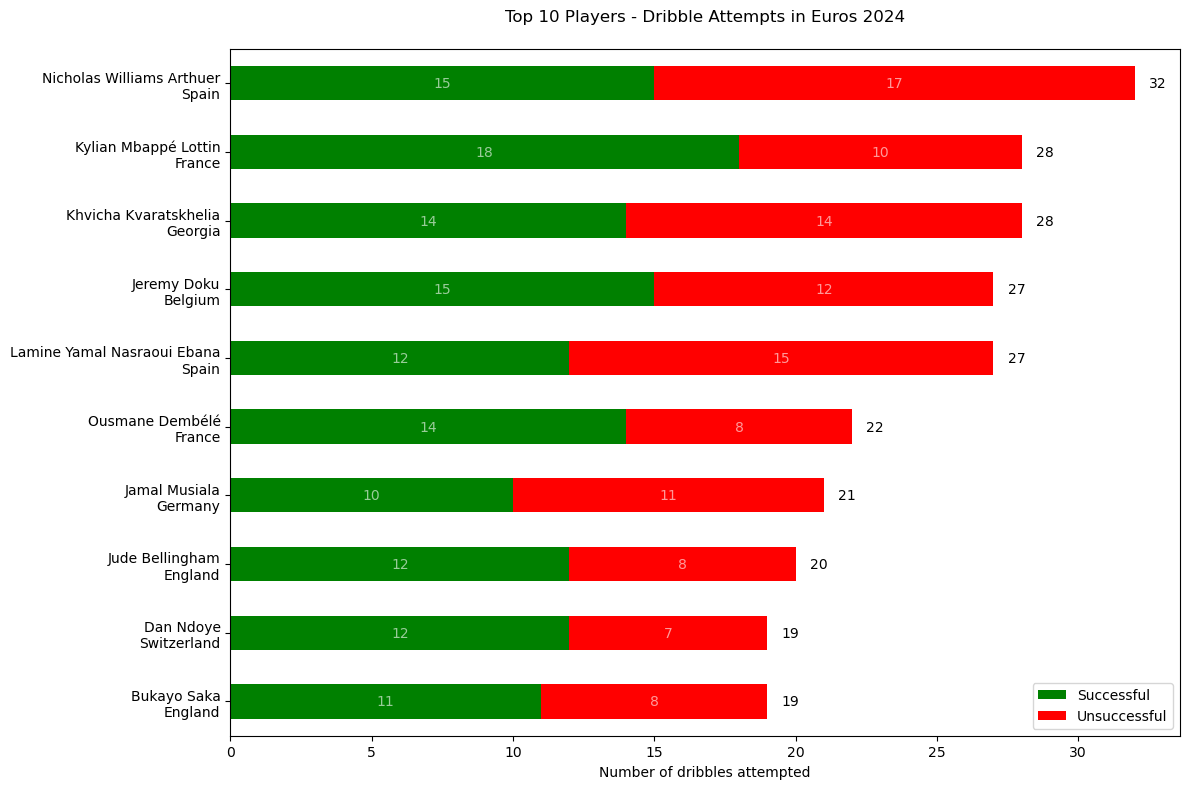

In [97]:
# Create a DataFrame with successful and unsuccessful dribbles per player
dribble_stats = df_dribbles.groupby(['player_name', 'outcome_name']).size().unstack(fill_value=0)

# Get the team name for each player (taking the first occurrence since players don't change teams in the tournament)
player_teams = df_dribbles.groupby('player_name')['team_name'].first()

# Sort by total dribbles and get top 10 players
dribble_stats['total'] = dribble_stats.sum(axis=1)
top_dribblers = dribble_stats.nlargest(10, ['total', 'Complete']).iloc[::-1]

# Add team names to the top dribblers
top_dribblers['team'] = player_teams[top_dribblers.index]
print(top_dribblers)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot stacked bars
top_dribblers['Complete'].plot(kind='barh', color='green', ax=ax)
top_dribblers['Incomplete'].plot(kind='barh', color='red', ax=ax, left=top_dribblers['Complete'])

# Add text annotations for Complete values
for i, v in enumerate(top_dribblers['Complete']):
    ax.text(v/2, i, str(v), 
            color='white',
            alpha=0.6,
            va='center',
            ha='center')

# Add text annotations for Incomplete values
for i, v in enumerate(top_dribblers['Incomplete']):
    ax.text(top_dribblers['Complete'][i] + v/2, i, str(v),
            color='white',
            alpha=0.6,
            va='center',
            ha='center')

# Customize the plot
plt.title('Top 10 Players - Dribble Attempts in Euros 2024', pad=20)
plt.xlabel('Number of dribbles attempted')
plt.ylabel(None)

# Create custom y-axis labels
ylabels = [f"{player}\n{team}" for player, team in zip(top_dribblers.index, top_dribblers['team'])]

# Set the labels with style properties
ax.set_yticklabels(ylabels, linespacing=1.2)

# Add legend
plt.legend(['Successful', 'Unsuccessful'])

# Add total numbers at the end of each bar
for i, player in enumerate(top_dribblers.index):
    total = top_dribblers.loc[player, 'total']
    plt.text(total + 0.5, i, str(int(total)), va='center')

# Adjust layout
plt.tight_layout()
plt.show()

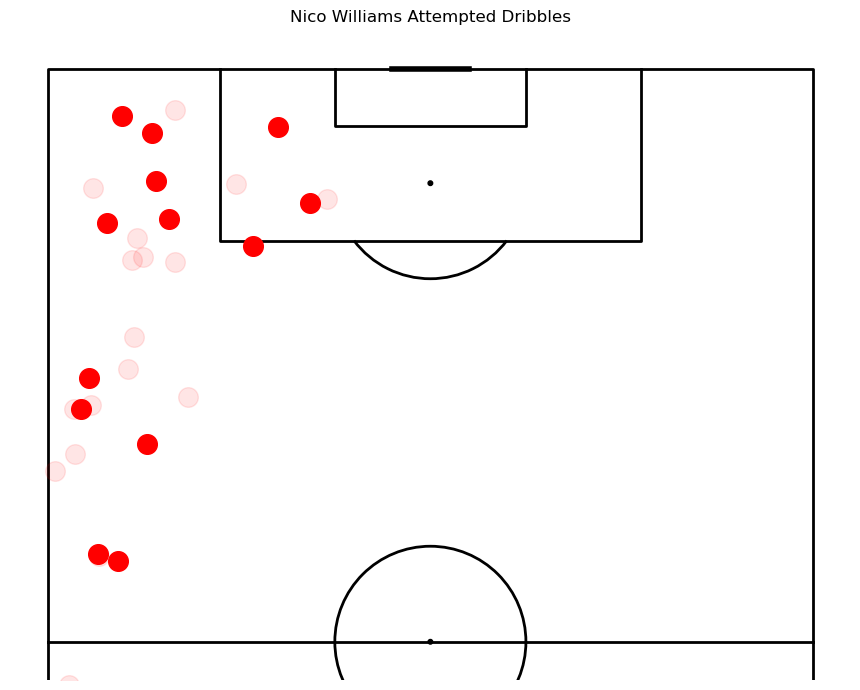

In [134]:
# Plotting Nico Williams dribbles

pitch = VerticalPitch(line_color='black', half=True)
fig, ax = pitch.draw(figsize=(10, 7))

# Add title
plt.title('Nico Williams Attempted Dribbles')

# Get all dribbles for Nico Williams
nico_dribbles = df_dribbles[df_dribbles['player_name'] == 'Nicholas Williams Arthuer']

# Plot successful and unsuccessful dribbles
for i, row in nico_dribbles.iterrows():
    if row['outcome_name'] == 'Complete':
        pitch.scatter(row['x'], row['y'], c='red', s=200, ax=ax)
    else:
        pitch.scatter(row['x'], row['y'], c='red', s=200, ax=ax, alpha=0.1)